In [22]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.25)

In [23]:
with open("../results/perlmutter/results.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.loc[results["method"] == "lazy", "method"] = "ProxyImports"
results

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup
0,1024,26075.313754,"[23.46285958500812, 24.98286917002406, 23.8725...",0.613515,48.946118,ProxyImports,tensorflow,16,10,78.332173
1,1024,75976.072964,"[71.20515765302116, 71.29346780700143, 71.3754...",0.455495,122.186891,file_system,tensorflow,16,10,0.004009
2,1024,12049.150416,"[14.354596584977116, 14.398935119970702, 14.58...",0.431667,66.616406,conda_pack,tensorflow,16,10,154.916764
3,1024,23091.081846,"[12.71142842801055, 12.985944583022501, 12.781...",0.596340,41.702482,ProxyImports,tensorflow,16,0,46.592275
4,1024,43498.181368,"[4.961286707024556, 5.028521177009679, 5.03124...",0.416571,111.452963,file_system,tensorflow,16,0,0.002724
...,...,...,...,...,...,...,...,...,...,...
583,8,80.731039,"[10.086286231991835, 10.086895045998972, 10.08...",0.007391,11.888772,file_system,numpy,8,10,0.001454
584,8,80.476865,"[10.04699319601059, 10.055880993022583, 10.055...",0.007042,18.474902,conda_pack,numpy,8,10,56.357462
585,8,2.213651,"[0.21409295999910682, 0.23427177197299898, 0.2...",0.013860,4.346782,ProxyImports,numpy,8,0,1.992409
586,8,1.806876,"[0.22730513795977458, 0.2266988240298815, 0.22...",0.007334,3.256876,file_system,numpy,8,0,0.001453


In [24]:
results["avg_time"] = results["times"].apply(lambda x: np.mean(x))
results["total_time"] = results["end_time"] + results["setup"]
results["tasks_per_node"] = results["ntasks"] / results["nodes"]
results.head()

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup,avg_time,total_time,tasks_per_node
0,1024,26075.313754,"[23.46285958500812, 24.98286917002406, 23.8725...",0.613515,48.946118,ProxyImports,tensorflow,16,10,78.332173,25.464174,127.278291,64.0
1,1024,75976.072964,"[71.20515765302116, 71.29346780700143, 71.3754...",0.455495,122.186891,file_system,tensorflow,16,10,0.004009,74.195384,122.190899,64.0
2,1024,12049.150416,"[14.354596584977116, 14.398935119970702, 14.58...",0.431667,66.616406,conda_pack,tensorflow,16,10,154.916764,11.766748,221.533170,64.0
3,1024,23091.081846,"[12.71142842801055, 12.985944583022501, 12.781...",0.596340,41.702482,ProxyImports,tensorflow,16,0,46.592275,22.549885,88.294757,64.0
4,1024,43498.181368,"[4.961286707024556, 5.028521177009679, 5.03124...",0.416571,111.452963,file_system,tensorflow,16,0,0.002724,42.478693,111.455687,64.0


In [25]:
conda_pack_results = results[results["method"] == "conda_pack"]
conda_pack_results[conda_pack_results["module"] == "numpy"]["setup"].mean()

59.54166381069214

In [26]:
conda_pack_results = results[results["method"] == "conda_pack"]
conda_pack_results[conda_pack_results["module"] == "tensorflow"]["setup"].mean()

144.18701301221986

In [27]:
lazy_results = results[results["method"] == "ProxyImports"]
lazy_results[lazy_results["module"] == "numpy"]["setup"].mean()

2.1030216266173034

In [28]:
lazy_results = results[results["method"] == "ProxyImports"]
lazy_results[lazy_results["module"] == "tensorflow"]["setup"].mean()

23.10145069810215

In [35]:
def plot_time_vs_tasks(nodes=1, modules=["numpy", "tensorflow"], y="avg_time", sleep=10, method = None):
    fig, axes = plt.subplots(1, len(modules), figsize=(12, 9))
    for i, module in enumerate(modules):
        df = results[results["nodes"] == nodes]
        df = df[df["sleep"] == sleep]
        df = df[df["module"] == module]
        if method is not None:
            df = df[df["method"] == method]
        
        sns.barplot(data=df, x="ntasks", y=y, hue="method", ax=axes[i])
        axes[i].set_title(f"Module: {module}")
        
    fig.suptitle(f"{y} for nodes: {nodes}")
    return fig, axes
    
def plot_time_vs_nodes(tasks=64, modules=["numpy", "tensorflow"], y="avg_time", sleep=10, method = None):
    fig, axes = plt.subplots(1, len(modules))
    if len(modules) == 1:
        axes = [axes]
    for i, module in enumerate(modules):
        df = results[results["tasks_per_node"] == tasks]
        df = df[df["sleep"] == sleep]
        df = df[df["module"] == module]
        if method is not None:
            df = df[df["method"] == method]
        
        sns.barplot(data=df, x="nodes", y=y, hue="method", ax=axes[i])
#         axes[i].set_title(f"{module}", fontsize=20)
    
    return fig, axes

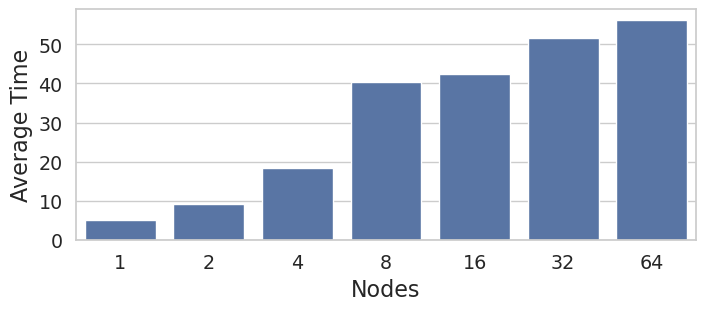

In [36]:
fig, axes = plot_time_vs_nodes(64, modules=["tensorflow"], sleep=0, method="file_system")
axes[0].get_legend().remove()
axes[0].set_title(None)
axes[0].set_xlabel("Nodes", fontsize=16)
axes[0].set_ylabel("Average Time", fontsize=16)
fig.set_size_inches(8, 3)
plt.savefig("figs/demo_import.pdf", bbox_inches="tight")

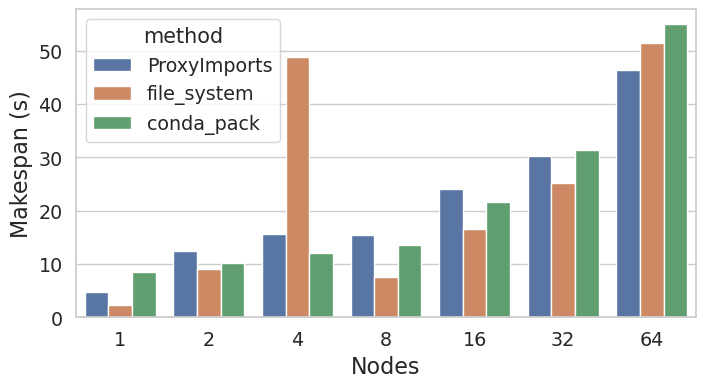

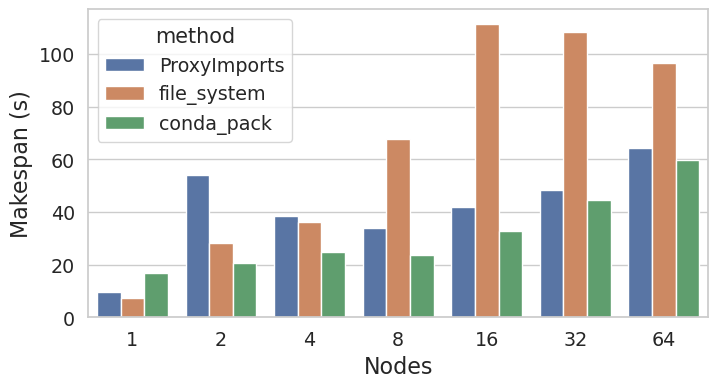

In [38]:
for module in ["numpy", "tensorflow"]:
    fig, axes = plot_time_vs_nodes(64, modules=[module], y="end_time", sleep=0)
#     axes[0].get_legend().remove()
    axes[0].set_xlabel("Nodes", fontsize=16)
    axes[0].set_ylabel("Makespan (s)", fontsize=16)
    fig.set_size_inches(8, 4)
    plt.savefig(f"figs/perlmutter_import_sleep_0_{module}.pdf", bbox_inches="tight")
    plt.show()

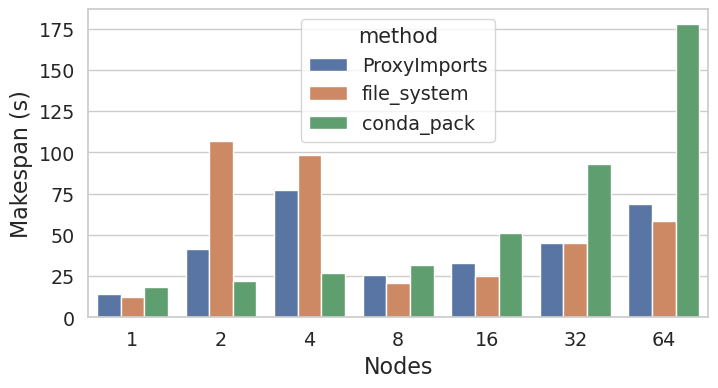

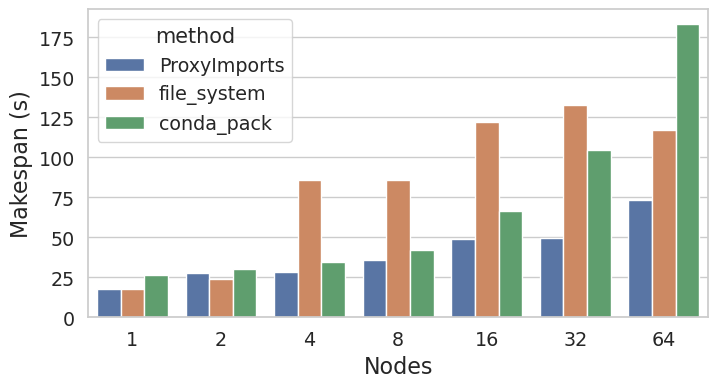

In [39]:
for module in ["numpy", "tensorflow"]:
    fig, axes = plot_time_vs_nodes(64, modules=[module], y="end_time", sleep=10)
#     axes[0].get_legend().remove()
    axes[0].set_xlabel("Nodes", fontsize=16)
    axes[0].set_ylabel("Makespan (s)", fontsize=16)
    fig.set_size_inches(8, 4)
    plt.savefig(f"figs/perlmutter_import_sleep_10_{module}.pdf", bbox_inches="tight")
    plt.show()

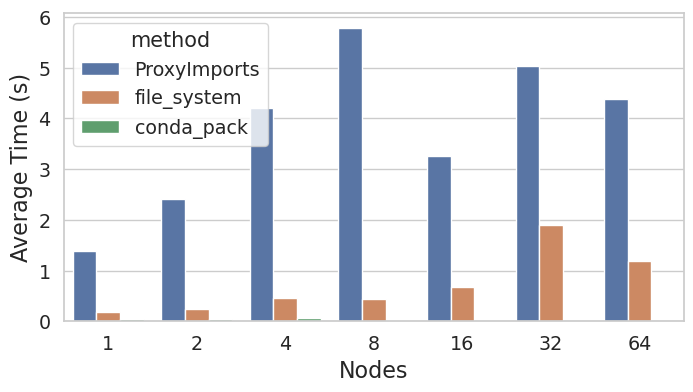

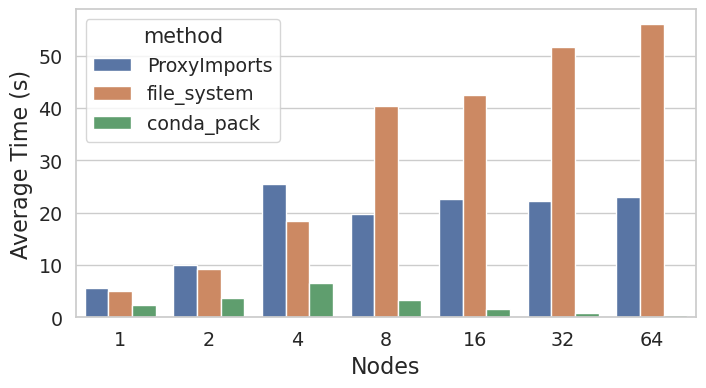

In [41]:
for module in ["numpy", "tensorflow"]:
    fig, axes = plot_time_vs_nodes(64, modules=[module], sleep=0)
#     axes[0].get_legend().remove()
    axes[0].set_xlabel("Nodes", fontsize=16)
    axes[0].set_ylabel("Average Time (s)", fontsize=16)
    fig.set_size_inches(8, 4)
    plt.savefig(f"figs/perlmutter_avg_time_{module}.pdf", bbox_inches="tight")
    plt.show()

In [42]:
with open("../results/perlmutter/results-simulated.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.loc[results["method"] == "lazy", "method"] = "ProxyImports"
results

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup,package_size
0,4096,13411.417200,"[1.9355399399937596, 1.978690504009137, 2.0278...",1.768655,60.686197,ProxyImports,sim_pack,64,0,5.512988,3
1,4096,79027.639175,"[11.596516666002572, 11.550000698014628, 11.59...",1.731617,66.572963,file_system,sim_pack,64,0,0.001416,3
2,4096,611.931150,"[1.6155969399842434, 1.6191201219917275, 1.617...",1.758430,57.579358,conda_pack,sim_pack,64,0,78.760177,3
3,4096,20630.357789,"[0.34214787400560454, 0.3435316260147374, 0.35...",1.743197,56.020622,ProxyImports,sim_pack,64,0,10.269810,6
4,4096,151345.785506,"[19.740995058004046, 19.662548886990407, 19.59...",1.797641,76.202780,file_system,sim_pack,64,0,0.001727,6
5,4096,1344.476893,"[4.416789002018049, 4.420643830002518, 4.41752...",1.861285,57.282606,conda_pack,sim_pack,64,0,79.793701,6
6,4096,31398.609281,"[0.25856026998371817, 0.30149046500446275, 0.2...",1.752799,51.248822,ProxyImports,sim_pack,64,0,15.242306,9
7,4096,181543.594038,"[35.186836124019464, 35.200170031021116, 35.20...",1.779805,79.487624,file_system,sim_pack,64,0,0.001872,9
8,4096,2565.441812,"[8.965489411988528, 8.973565766995307, 8.97495...",1.712653,57.621760,conda_pack,sim_pack,64,0,101.535136,9
9,4096,37388.486521,"[0.4298054160026368, 0.4305210029997397, 0.473...",1.986052,52.078695,ProxyImports,sim_pack,64,0,20.309409,12


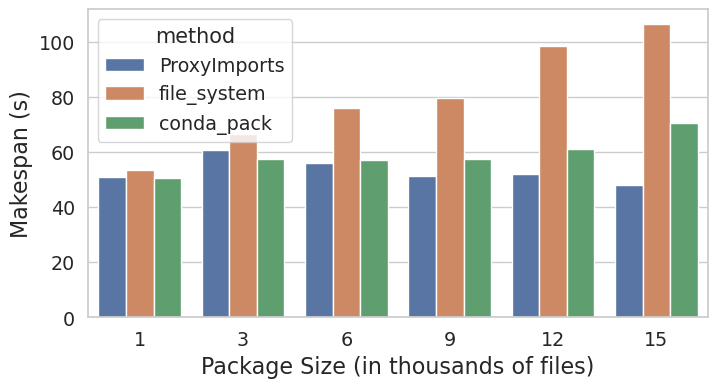

In [43]:
fig, axes = plt.subplots(figsize=(8, 4))
sns.barplot(data=results, x="package_size", y="end_time", hue="method", ax=axes)
axes.set_xlabel(f"Package Size (in thousands of files)", fontsize=16)
axes.set_ylabel(f"Makespan (s)", fontsize=16)
plt.savefig("figs/perlmutter_simulated_package.pdf", bbox_inches="tight")

In [19]:
with open("../results/perlmutter/xtb_results.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.loc[results["method"] == "lazy", "method"] = "ProxyImports"
results

,method,nodes,initial,count,batch,time
0,ProxyImports,64,4096,16384,4096,76.567775
1,file_system,64,4096,16384,4096,77.255843
2,ProxyImports,64,4096,16384,4096,71.120564
3,file_system,64,4096,16384,4096,61.999371
4,ProxyImports,64,4096,16384,4096,72.874247
5,file_system,64,4096,16384,4096,64.936000
6,ProxyImports,64,4096,16384,4096,99.371140
7,file_system,64,4096,16384,4096,62.403770
8,ProxyImports,64,4096,16384,4096,74.141615
9,file_system,64,4096,16384,4096,71.000000


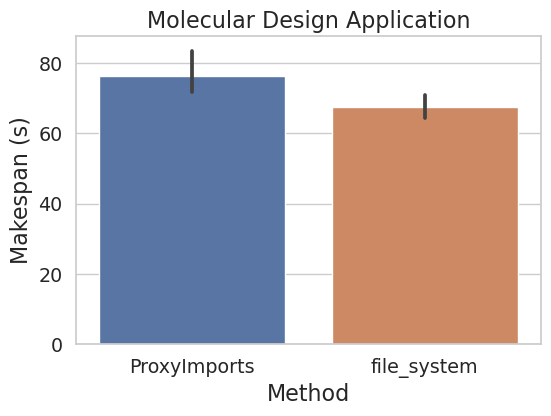

In [20]:
fig, axes = plt.subplots(figsize=(6, 4))
sns.barplot(data=results, x="method", y="time", ax=axes)
axes.set_xlabel(f"Method", fontsize=16)
axes.set_ylabel(f"Makespan (s)", fontsize=16)
plt.title(f"Molecular Design Application", fontsize=16)
plt.savefig("figs/perlmutter_mol_design.pdf", bbox_inches="tight")

In [21]:
speedup = results[results["method"] == "file_system"]["time"].mean() / results[results["method"] == "ProxyImports"]["time"].mean() 
print("Overall Speedup: ", speedup)

Overall Speedup:  0.8829595735741934
